# Welcome!

Welcome to the tutorial of the ai4eo_forecast python library. In the following the different features of the library going to be presented through an exaqmple workflow of processing data. I hope this is going to be useful but in case of you find any any problem, please contact us by opening an issue in the tracker at gitlab: https://gitlab.com/DeepBlueGlobe/ai4eo-forecast

## Structure of the library

The library is separated into three different modules:
* utility
* visualization
* data_fetcher

### Utility
This module contains commonly used algorithms to make your life easier while processing and evaluating data.

### Visulaization
This module helps in visualizing and animating geographical data out of the box in a fancy way. These are especially useful to explore your data before you would like to create your own fancy figure/animation.

### DataFetcher
It is often happens that you need to grab some data from a given FTP server to be able to create your own time series. The catch is that the previous data is often removed from the server. This tool makes it possible to save every data from the given repo when it is updated and it even stores the details in a local database file.

## Under the hood
ai4eo_forecast is based on [xarray](http://xarray.pydata.org) and [dask](https://dask.org/). These libraries were used because of the provided high flexibility, scaling and rich features. Visualziation is based on [cartopy](https://scitools.org.uk/cartopy) and [matplotlib](https://matplotlib.org/).

# Acquiring data

The first step if you would like to process data is to get some. In the following I am going to use data from the [Copernicus Marine Environment Monitoring Service](http://marine.copernicus.eu/). Let's say we would like to get each day from here the weather forecast for the upcoming days. To be able to do this we need to visit each day their respository and download the new data (while the old one is already removed by the data provider). To make this process automatic you can use the DataFetcher class from data_fetcher module. Probaly you would like to use this with command line options so you should create a script with the following content:

```python
from ai4eo_forecast.data_fetcher import DataFetcher

df = DataFetcher(cmd=True)
df.fetch()
```

This could be invoked then with the necessary parameters:

```bash
python download.py "nrt.cmems-du.eu" "Core/GLOBAL_ANALYSIS_FORECAST_PHY_001_024/global-analysis-forecast-phy-001-024-hourly-t-u-v-ssh/" --user 'username' --password 'password' --loop --now
```

# Processing data
Let's say you have two datasets for a given time what you would like to compare with each other but you are not sure whether they are compatible or not. So, what are we doing first? As it was said earlier, under the hood `ai4eo_forecast` uses dask and xarray. Dask should be initilaized first:

In [1]:
from dask.distributed import Client

client = Client(n_workers=2, threads_per_worker=2, memory_limit='2GB')
client

<Client: scheduler='tcp://127.0.0.1:40179' processes=2 cores=4>

Now that, dask is prepared we should load our datasets. I downloaded two different datasets which contain the same data (surface temperature) and same area but with different sampling:

* GLOBAL_ANALYSIS_FORECAST_PHY_001_024
* MEDSEA_ANALYSIS_FORECAST_PHY_006_013

I am going to compare these to each other:

In [2]:
import xarray as xr

/home/peterffy/.conda/envs/socis2/lib/python3.7/site-packages/xarray/core/merge.py:17: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)


In [3]:
dataset_one = xr.open_dataset("mercatorpsy4v3r1_gl12_hrly_20190813_R20190810_20190810014946.nc", chunks={"time":"auto"})
dataset_two = xr.open_dataset("20190813_d-CMCC--TEMP-MFSeas4-MEDATL-b20190827_an-sv05.00.nc", chunks={"time":"auto"})

Have a look at the data structure:

In [4]:
dataset_one

<xarray.Dataset>
Dimensions:    (depth: 1, latitude: 2041, longitude: 4320, time: 24)
Coordinates:
  * longitude  (longitude) float32 -180.0 -179.91667 ... 179.83333 179.91667
  * latitude   (latitude) float32 -80.0 -79.916664 -79.833336 ... 89.916664 90.0
  * depth      (depth) float32 0.494025
  * time       (time) datetime64[ns] 2019-08-13T00:30:00 ... 2019-08-13T23:30:00
Data variables:
    zos        (time, depth, latitude, longitude) float32 dask.array<shape=(24, 1, 2041, 4320), chunksize=(3, 1, 2041, 4320)>
    thetao     (time, depth, latitude, longitude) float32 dask.array<shape=(24, 1, 2041, 4320), chunksize=(3, 1, 2041, 4320)>
    uo         (time, depth, latitude, longitude) float32 dask.array<shape=(24, 1, 2041, 4320), chunksize=(3, 1, 2041, 4320)>
    vo         (time, depth, latitude, longitude) float32 dask.array<shape=(24, 1, 2041, 4320), chunksize=(3, 1, 2041, 4320)>
Attributes:
    title:              hourly mean fields from Global Ocean Physics Analysis...
    easti

In [5]:
dataset_two

<xarray.Dataset>
Dimensions:  (depth: 141, lat: 380, lon: 1287, time: 1)
Coordinates:
  * lon      (lon) float32 -17.291666 -17.25 -17.208334 ... 36.25 36.291668
  * lat      (lat) float32 30.1875 30.229166 30.270834 ... 45.9375 45.979168
  * time     (time) datetime64[ns] 2019-08-13
  * depth    (depth) float32 1.0182366 3.1657474 5.4649634 ... 5646.199 5754.044
Data variables:
    bottomT  (time, lat, lon) float32 dask.array<shape=(1, 380, 1287), chunksize=(1, 380, 1287)>
    thetao   (time, depth, lat, lon) float32 dask.array<shape=(1, 141, 380, 1287), chunksize=(1, 141, 380, 1287)>
Attributes:
    comment:        Please check in CMEMS catalogue the INFO section for prod...
    field_type:     daily_mean_centered_at_time_field
    title:          Potential Temperature (3D) - Daily Mean
    Conventions:    CF-1.0
    source:         MFS EAS4
    contact:        servicedesk.cmems@mercator-ocean.eu
    references:     Please check in CMEMS catalogue the INFO section for prod...
    bul

Let's check their compatibility:

In [23]:
import ai4eo_forecast.utility as a4u

In [7]:
report = a4u.compatibility_check(dataset_one, dataset_two)
report.show()

# Compatible dimensions
# Incompatible dimensions
depth, depth
time, time


The first thing what you can notice, that we do not see all the dimensions here, because where no name connection could be made between the two datasets, they are ignored from the report. An other thing what you can notice that the other variables where a connection was found are not compatible each other (they do not have overlapping ranges). This is because one of the datasets is a hourly forecast while the other is for a whole day. If you check they do not have common time values. Also, the depth is also not compatible in the sense of they do not have interlapping ranges, but this is not a problem. They have a "close enough" value. We are going to use that.

But first, what can we do if the naming is not the same in the two datasets? We should create a dimension mapping dictionary:

In [11]:
dimension_map = {"lat" : "latitude",
                 "lon" : "longitude",
                 "depth" : "depth",
                 "time" : "time"}

In [12]:
report = aiu.compatibility_check(dataset_one, dataset_two, dimension_map)
report.show()

# Compatible dimensions
lat, latitude, mutual range: 30.1875 45.97916793823242
lon, longitude, mutual range: -17.29166603088379 36.29166793823242
# Incompatible dimensions
depth, depth
time, time


At this point, it should be considered to have a look at our data plotted. We can do that easily by the following:

In [13]:
import ai4eo_forecast.visualization as a4v

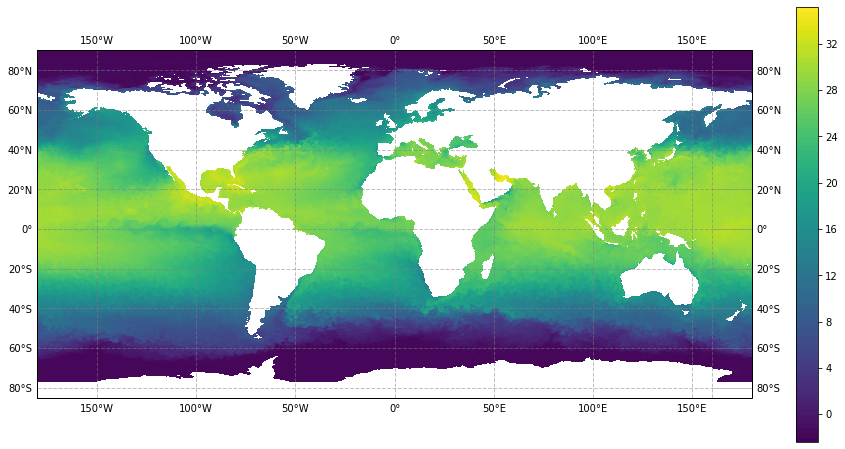

In [14]:
a4v.plot_geographic_data(dataset_one["thetao"][dict(depth=0, time=0)], figsize=(16,8))

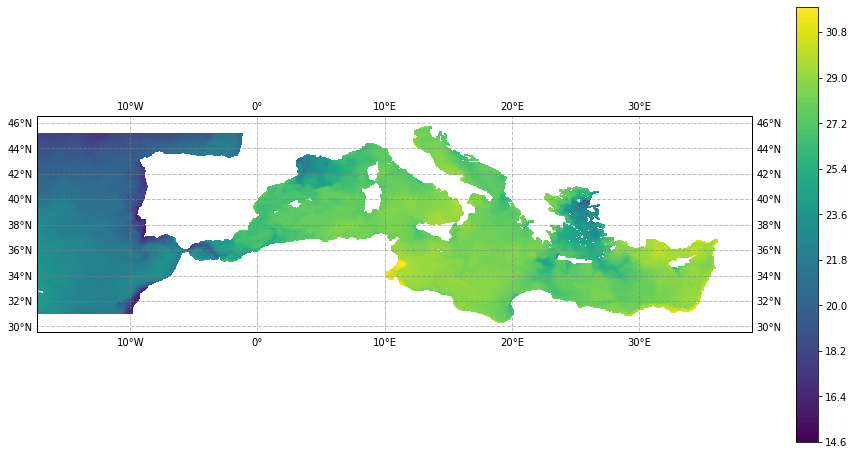

In [15]:
a4v.plot_geographic_data(dataset_two["thetao"][dict(depth=0, time=0)], figsize=(16,8), latitude="lat", longitude="lon")

Now we should check for differences eg. in surface temperature values (thetao). Eg. from the hourly dataset we will choose the first time entry for that. We need to make the two datasets compatible with each other. For that we are going to use the builtin feature of xarray:

In [16]:
# Select data
selected_one = dataset_one["thetao"][dict(depth=0, time=0)]
selected_two = dataset_two["thetao"][dict(depth=0, time=0)]

In [17]:
# Rename dimensions so the interpolation can work
selected_two = selected_two.rename({"depth" : "depth",
                                    "time" : "time",
                                    "lat" : "latitude",
                                    "lon" : "longitude"})

In [18]:
# Interpolate
interpolated_one = selected_one.interp_like(selected_two)

Now we can compare them:

In [19]:
import numpy as np

In [20]:
difference = np.fabs(interpolated_one - selected_two)

Plot it:

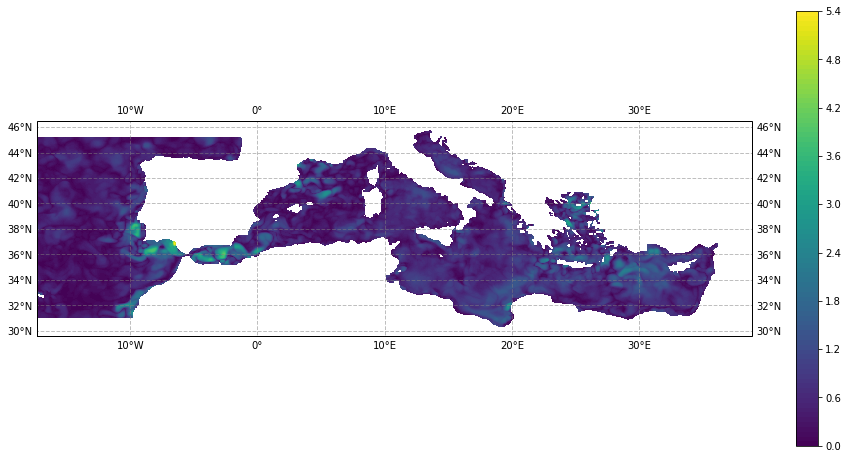

In [21]:
a4v.plot_geographic_data(difference, figsize=(16,8))

You can also check the mean square error between the two datasets:

In [26]:
a4u.calculate_msqe_between_datasets(interpolated_one, selected_two).compute()

<xarray.DataArray 'thetao' ()>
array(0.499052, dtype=float32)
Attributes:
    name:     Mean square error

# Compare forecasts to a given dataset

Let's say we have different forecasts for a given day. E.g. a forecast from each day before the actual measurement and we would like to check, how the forecast got better or worse as we got closer to the given data. To be able to do that, we need the data ordered by how they follow each other into a list. If you have the data in a folder you can use ai4eo_forecast to help you load it, if the dataset names are in ascending order.

So this is how you can load the data:

In [27]:
# This is the folder which contains the data
path_to_data = "time_series_comparison/data"

In [29]:
# Find the files with .nc extension and place them in a list
files = a4u.find_nc_files_in_folder(path_to_data)
files

['time_series_comparison/data/mercatorpsy4v3r1_gl12_hrly_20190813_R20190809_20190809014225.nc',
 'time_series_comparison/data/mercatorpsy4v3r1_gl12_hrly_20190813_R20190810_20190810014946.nc',
 'time_series_comparison/data/mercatorpsy4v3r1_gl12_hrly_20190813_R20190811_20190811014240.nc',
 'time_series_comparison/data/mercatorpsy4v3r1_gl12_hrly_20190813_R20190812_20190812013845.nc',
 'time_series_comparison/data/mercatorpsy4v3r1_gl12_hrly_20190813_R20190813_20190813014113.nc',
 'time_series_comparison/data/mercatorpsy4v3r1_gl12_hrly_20190813_R20190814_20190814014428.nc',
 'time_series_comparison/data/mercatorpsy4v3r1_gl12_hrly_20190813_R20190814_20190814124044.nc',
 'time_series_comparison/data/mercatorpsy4v3r1_gl12_hrly_20190813_R20190821_20190818212440.nc']

In [30]:
# Load the data
data = a4u.load_data_into_list(files)

At this point we have the paths to the files and the datasets corresponding, loaded into two lists where the same index represents the same path/data. We know that we have the forecast before the last two entry and the last two are the actual analysis data. We should separate our data accordingly:

In [31]:
actual = data[-2]
forecasts = data[0:-2]

Nice to store the filenames as well. It is going to make a good service when we start to compare data.

In [32]:
import ntpath

actual_filename = ntpath.basename(files[-2])
forecasts_filenames = []
for i in files[0:-2]:
    forecasts_filenames.append(ntpath.basename(i))

Let's compare again the surface temperatures. We can check how the mean_square_error changed during the different forecasts:

In [44]:
msqe = a4u.calculate_msqe_between_datasets(forecasts,
                                           actual,
                                           data_filename=forecasts_filenames,
                                           reference_filename=actual_filename,
                                           mean_along_axis=("longitude", "latitude")
                                          )

And now plot it with matploltib:

In [34]:
import matplotlib.pyplot as plt

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

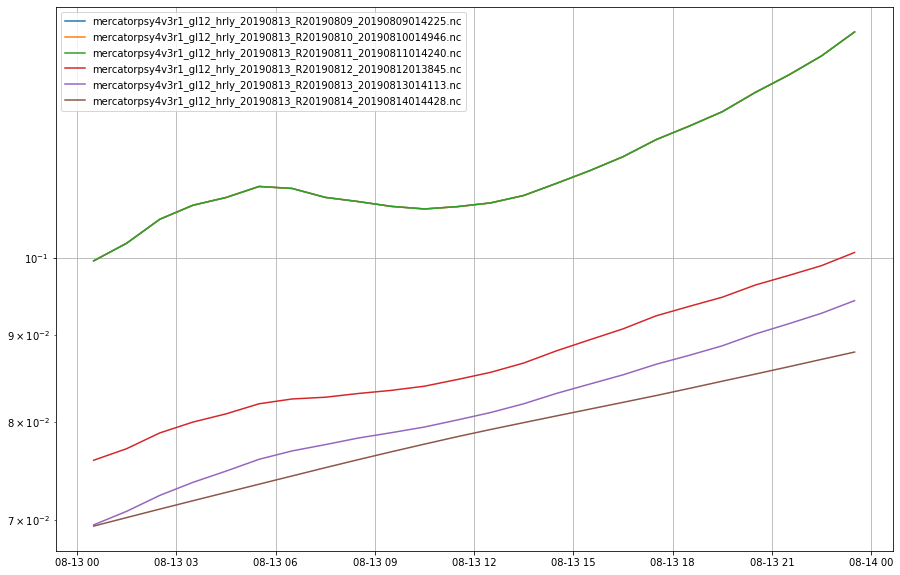

In [46]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1,1,1)
for i in msqe:
        ax.semilogy(i["thetao"]["time"], i["thetao"], label=i.attrs["filename"])
plt.grid()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)
plt.show()

Now let's see what happens, if we calculate this along for example the time dimension, and we create a movie!

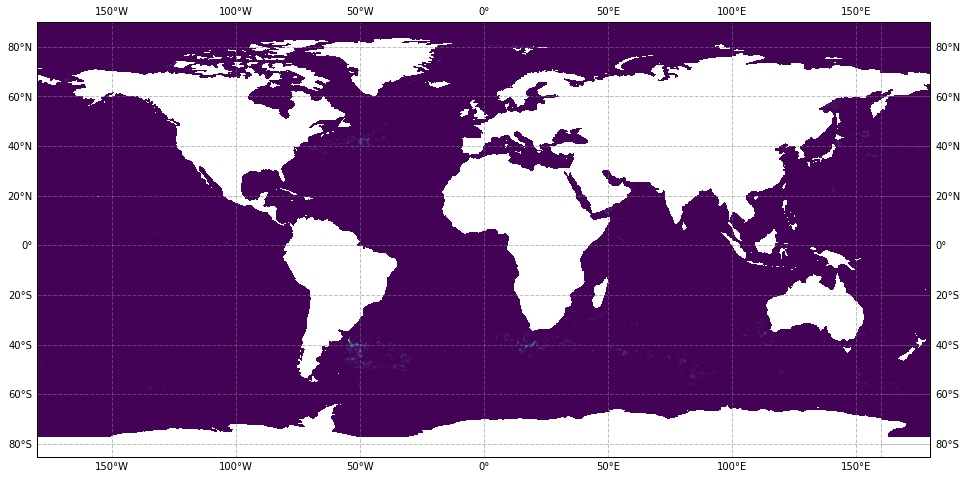

In [53]:
msqe =  a4u.calculate_msqe_between_datasets(forecasts,
                                           actual,
                                           data_filename=forecasts_filenames,
                                           reference_filename=actual_filename,
                                           mean_along_axis=("time")
                                          )

# Select the thetao variable
msqe_selected = []
for i in msqe:
    msqe_selected.append(i["thetao"][dict(depth=0)])

anim = a4v.create_geographic_animation(msqe_selected,
                                      figsize=(16,8))

Now we need some Jupyter magic to show the movie:

In [ ]:
from IPython.display import HTML

In [55]:
HTML(anim.to_html5_video())

You can do this with logarithmic coloring as well, because right now e did not see anything changing:

/home/peterffy/.conda/envs/socis2/lib/python3.7/site-packages/matplotlib/contour.py:1523: RuntimeWarning: invalid value encountered in less_equal
  z = ma.masked_where(z <= 0, z)
/home/peterffy/.conda/envs/socis2/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1400: UserWarning: Log scale: values of z <= 0 have been masked
  result = matplotlib.axes.Axes.contourf(self, *args, **kwargs)
/home/peterffy/.conda/envs/socis2/lib/python3.7/site-packages/matplotlib/contour.py:1523: RuntimeWarning: invalid value encountered in less_equal
  z = ma.masked_where(z <= 0, z)
/home/peterffy/.conda/envs/socis2/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1400: UserWarning: Log scale: values of z <= 0 have been masked
  result = matplotlib.axes.Axes.contourf(self, *args, **kwargs)
/home/peterffy/.conda/envs/socis2/lib/python3.7/site-packages/matplotlib/contour.py:1523: RuntimeWarning: invalid value encountered in less_equal
  z = ma.masked_where(z <= 0, z)
/home/peterffy/.conda/envs/socis2/lib

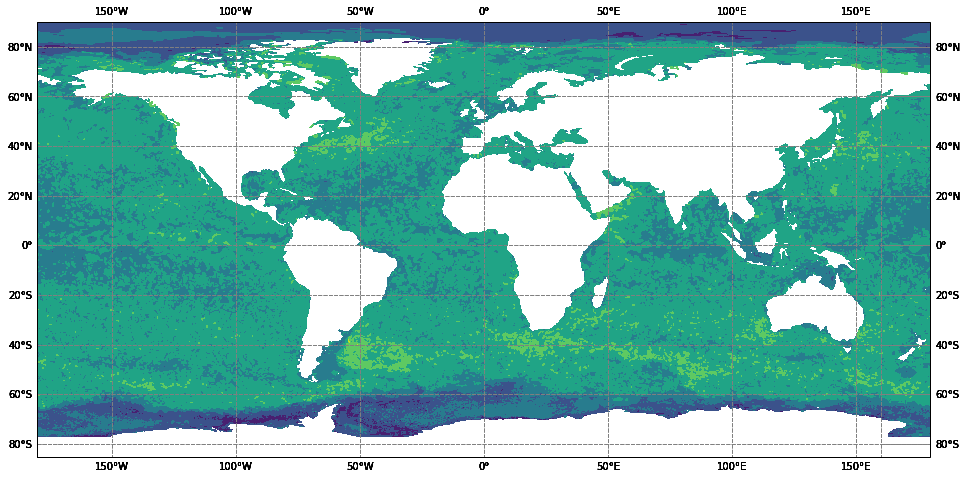

In [57]:
from matplotlib import ticker
HTML(a4v.create_geographic_animation(msqe_selected, figsize=(16,8), locator=ticker.LogLocator()).to_html5_video())